In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import subprocess
%matplotlib inline

import cv2
from sklearn.cluster import KMeans
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
class GMM(object):
    
    weights = None
    means = None
    covars = None
    k=None
    iterations =100
    convergence_th=1e-3
    ric=None
    
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        """
        A Gaussian mixture model trained via the expectation maximization
        algorithm.
        
        Parameters
        ----------
        
        n_components: The number of mixture components.
        tol: The convergence threshold
        """
        self.k=n_components
        self.iterations=max_iter
        self.convergence_th=tol


    def initialize_params(self, X, kmeans=False):
        """
        Initialize the starting GMM parameters.
        
        Parameters
        ----------
        X : A collection of `N` training data points, each with dimension `d`.
        kmeans: A boolean flag for determining if to initialize the params with kmeans or randomly.
        """

        self.means = np.random.rand(self.k,X.shape[1])
        self.covars = np.zeros((self.k, X.shape[1], X.shape[1]))
        for k in range(self.k):
            self.covars[k] = np.eye(X.shape[1])
        self.weights=[1/self.k]*self.k
        self.ric = np.zeros((X.shape[0], self.k))
    
    def formula(self,x,u,sigma,d):
        first_term = 1/(((2*np.pi)**(d/2))*np.sqrt(sigma))
        exp = -0.5*(np.dot(np.dot((x-u).T,np.linalg.inv(sigma)),(x-u)))
        second_term = np.exp(exp)
        return first_term*second_term
    
    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters
        
        Parameters
        ----------
        X : A collection of `N` data points, each with dimension `d`.
        """
        n=X.shape[0]
        d = X.shape[1]

        nan_mask = np.isnan(self.covars)
        inf_mask = np.isinf(self.covars)
        self.covars[nan_mask] = 1e-6
        self.covars[inf_mask] = 1e-6
        
        for c in range(self.k):
            self.ric[:,c]= self.weights[c]*multivariate_normal.pdf(X,mean=self.means[c],cov=self.covars[c],allow_singular=True)
        for i in range(n):
            self.ric[i] = self.ric[i]/np.sum(self.ric[i])
        return

    def M_step(self, X):
        """
        Updates parameters maximizing the expected log-likelihood found on the E step.
        
        Parameters
        ----------
        X : A collection of `N` data points, each with dimension `d`.
        """
        n=X.shape[0]
        d=X.shape[1]

        for c in range(self.k):
            self.weights[c]=np.sum(self.ric[:,c])/n
            
        for c in range(self.k):
            clusterSum = np.sum(self.ric[:, c])
            self.means[c] = np.sum(X * self.ric[:, c][:, np.newaxis], axis=0) / clusterSum
            diff = X - self.means[c]

            self.covars[c] = (np.dot(self.ric[:, c] * diff.T, diff)/ clusterSum) 
            self.weights[c] = clusterSum / n

        

    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.
        
        Parameters
        ----------
        X : A collection of `N` training data points, each with dimension `d`.
        y: not used
        """
        self.initialize_params(X)
        for i in range(self.iterations):
            self.E_step(X)
            self.M_step(X)
        
    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        
        Parameters
        ----------
        X : A collection of `M` data points, each with dimension `d`.
        
        Returns
        -------
        Predicted labels.
        """
        N = X.shape[0]
        gamma = np.zeros((N, self.k))
        for k in range(self.k):
            pdf = multivariate_normal(mean=self.means[k], cov=self.covars[k])
            gamma[:, k] = self.weights[k] * pdf.pdf(X)
        return np.argmax(gamma, axis=1)

In [3]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'
print(source_path)
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}" 
print(frames_path)


!mkdir -p {frames_path} > /dev/null ;


os.makedirs(frames_path, exist_ok=True)

print(f"Source file exists: {os.path.exists(source_path)}, Path: {source_path}")
subprocess.run([
    "ffmpeg", "-i", source_path, f"{frames_path}/frame_%04d.png"
], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

./videos/traffic.gif
./frames/traffic
Source file exists: True, Path: ./videos/traffic.gif


ϵͳ�Ҳ���ָ����·����


CompletedProcess(args=['ffmpeg', '-i', './videos/traffic.gif', './frames/traffic/frame_%04d.png'], returncode=0)

In [4]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
    
frames = np.asarray(frames, dtype=np.float64)

In [5]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

# train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=True, random_state=1)
train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


  1%|          | 1/120 [00:00<01:16,  1.55it/s]C:\Users\sunbinyan\AppData\Local\Temp\ipykernel_38212\2207033947.py:88: RuntimeWarning: invalid value encountered in divide
  self.means[c] = np.sum(X * self.ric[:, c][:, np.newaxis], axis=0) / clusterSum
 48%|████▊     | 57/120 [00:24<00:26,  2.39it/s]C:\Users\sunbinyan\AppData\Local\Temp\ipykernel_38212\2207033947.py:69: RuntimeWarning: invalid value encountered in divide
  self.ric[i] = self.ric[i]/np.sum(self.ric[i])
100%|██████████| 120/120 [00:50<00:00,  2.35it/s]


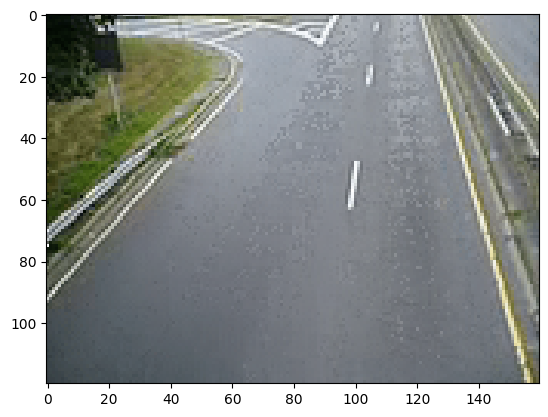

In [6]:
from tqdm import tqdm
from sklearn.mixture import GaussianMixture


gmm_background = np.zeros(shape = (train_frames.shape[1], train_frames.shape[2], 3))

for i in tqdm(range(train_frames.shape[1])):
    for j in range(train_frames.shape[2]):
#         for k in range(train_frames.shape[3]):
        X = train_frames[:, i, j, :]
        X = X.reshape(X.shape[0], 3)
#         allSame=True
#         for i in range(1,X.shape[0]):
#             if X[i-1]!=X[i]:
#                 allSame=False
#         if allSame:
#             background[i][j] = X[0][0]
#         else:
        gmm = GMM(2,max_iter=5)
        gmm.fit(X)
        means = gmm.means
        weights = gmm.weights
        idx = np.argmax(weights)
        gmm_background[i][j][:] = means[idx]
            #print(int(means[idx]))
plt.imshow(gmm_background)
plt.show()
#cv2.imwrite('background.png', background)

C:\Users\sunbinyan\AppData\Local\Temp\ipykernel_38212\3941678651.py:5: RuntimeWarning: invalid value encountered in cast
  foregrounds = np.array(foregrounds,dtype='uint8')


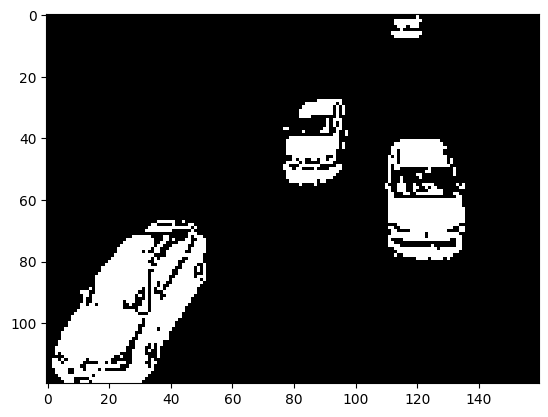

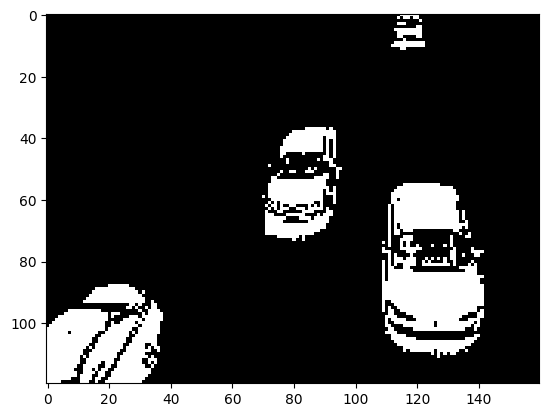

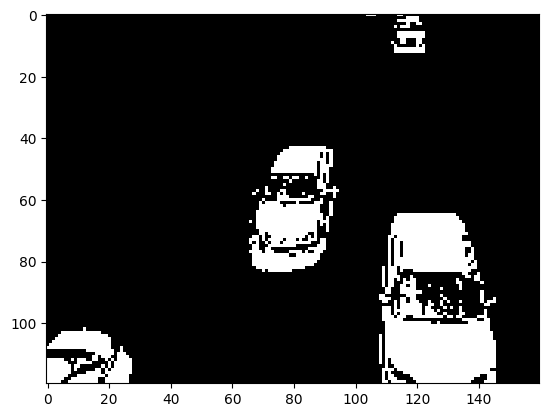

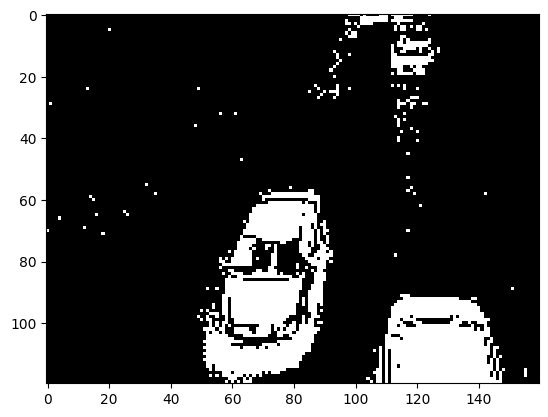

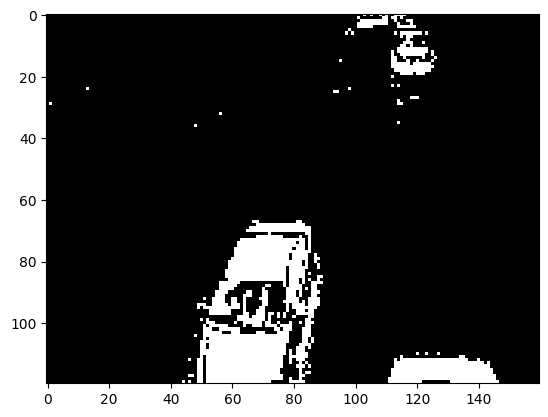

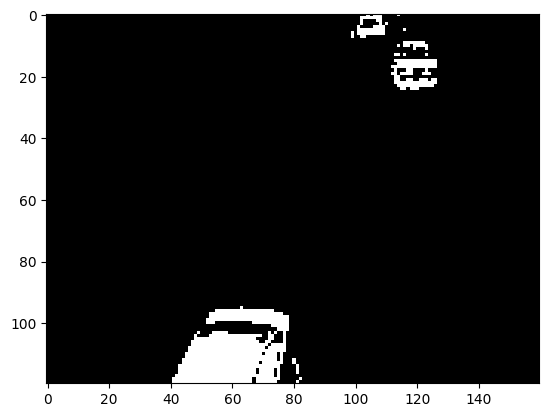

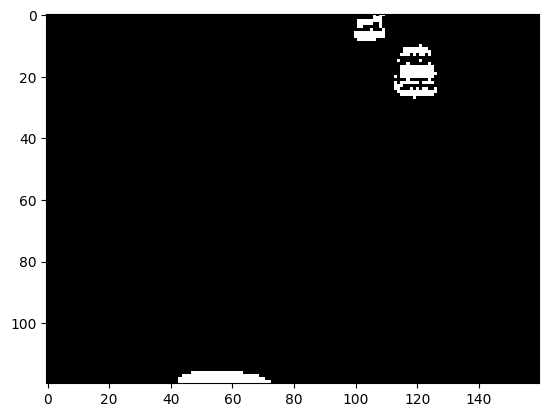

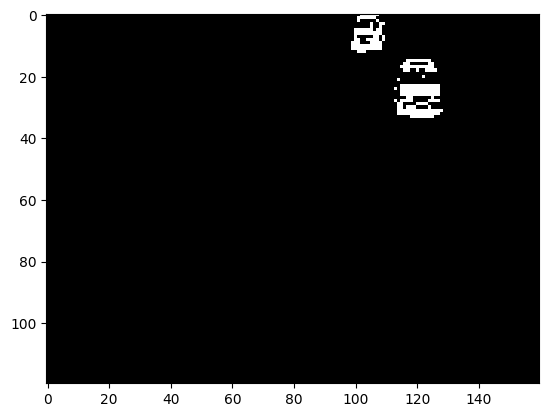

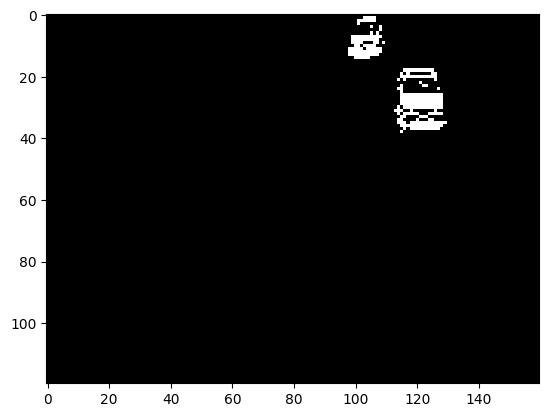

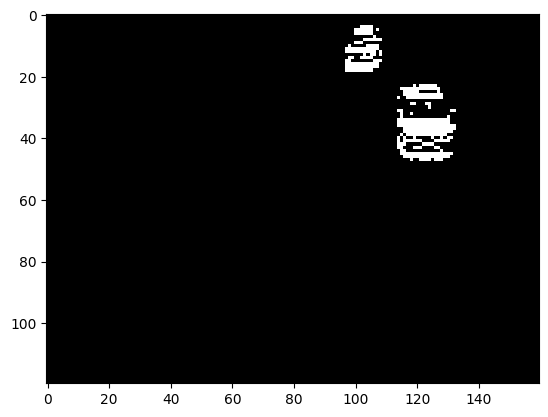

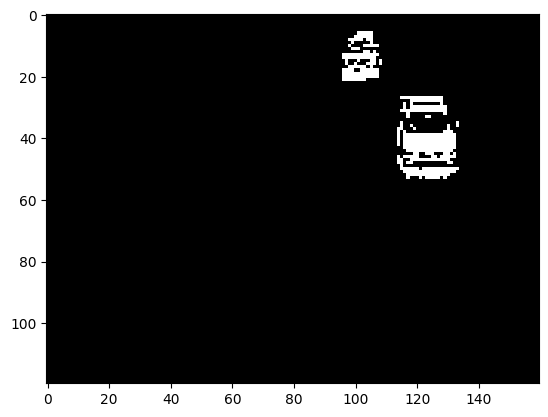

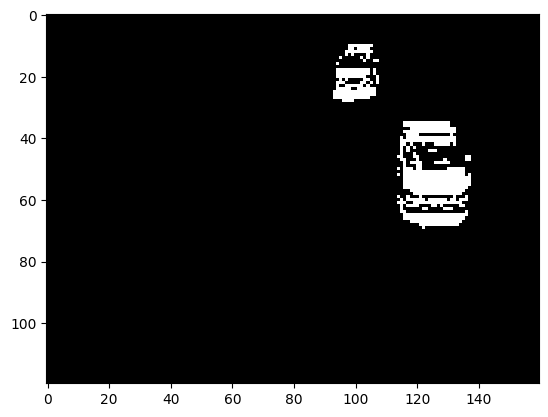

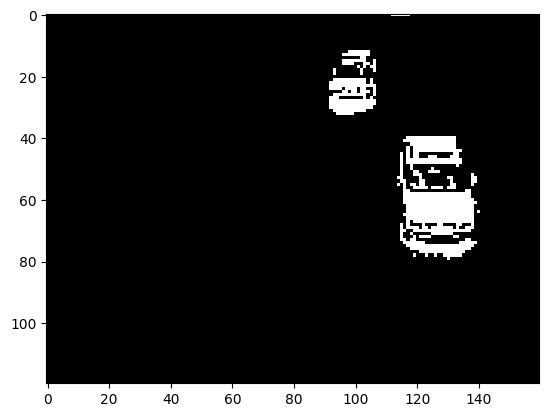

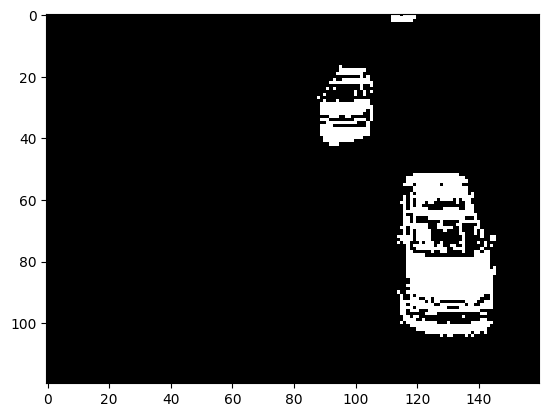

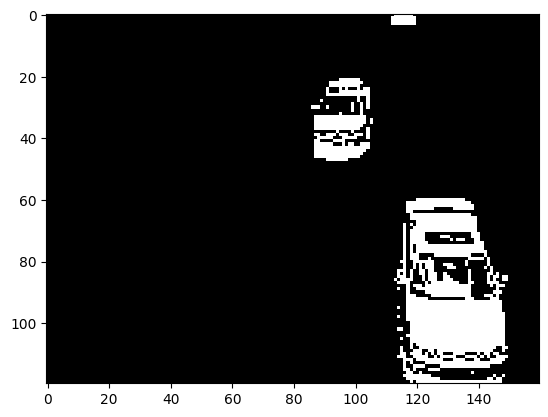

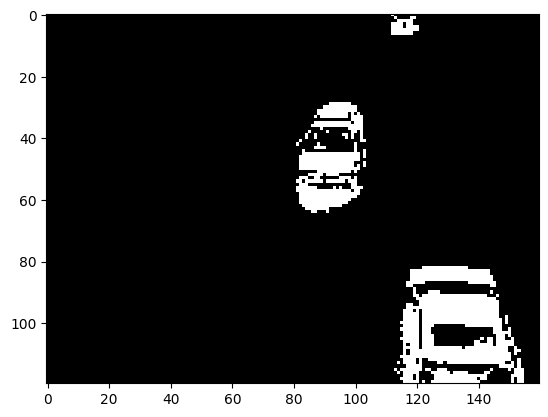

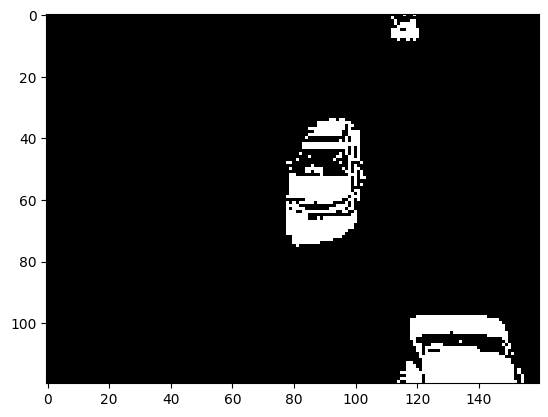

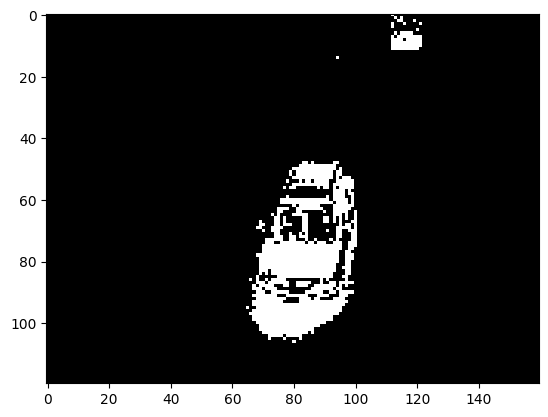

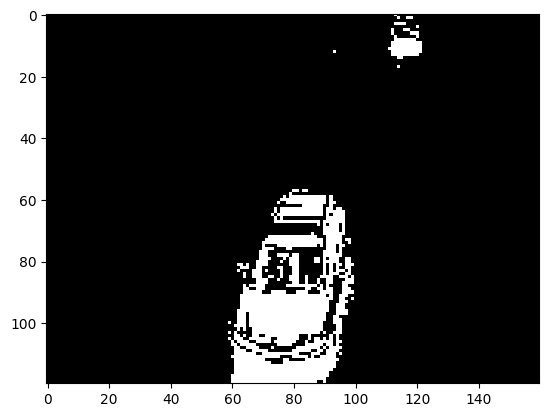

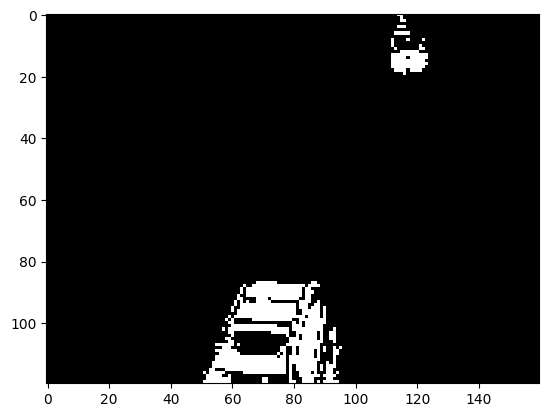

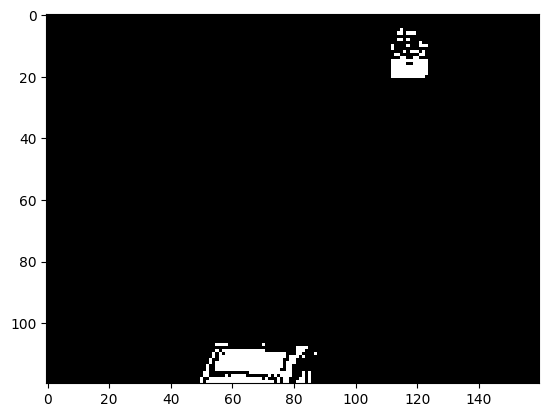

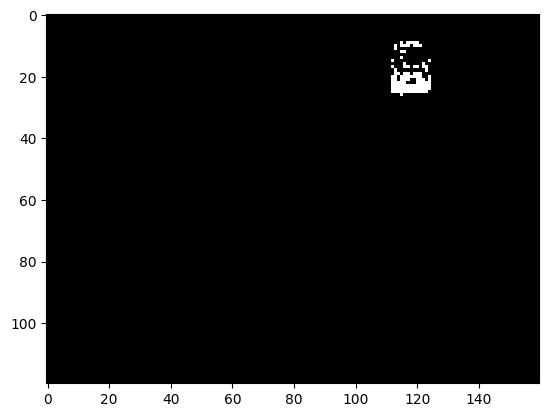

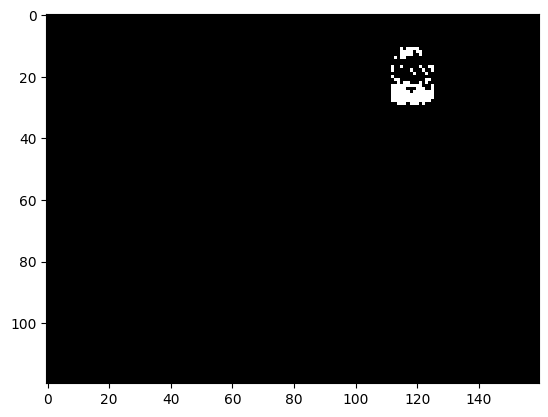

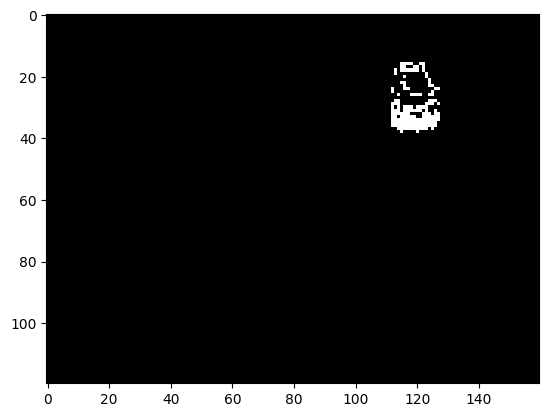

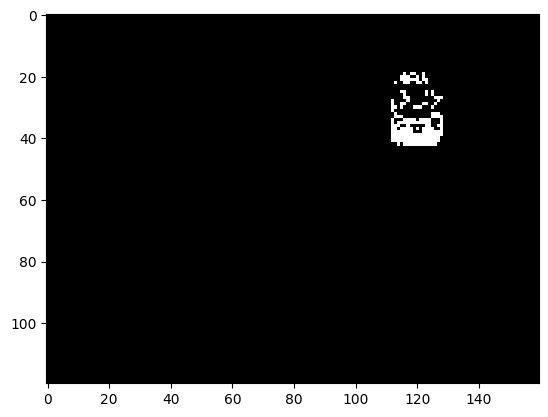

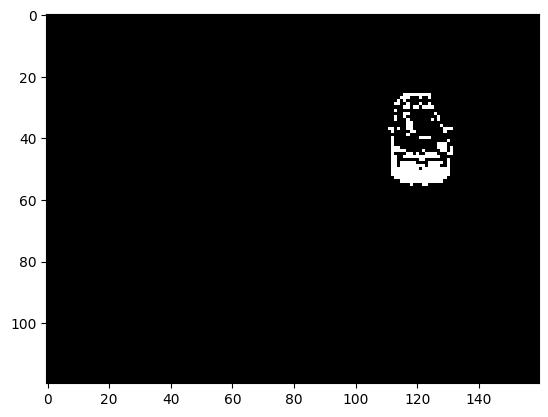

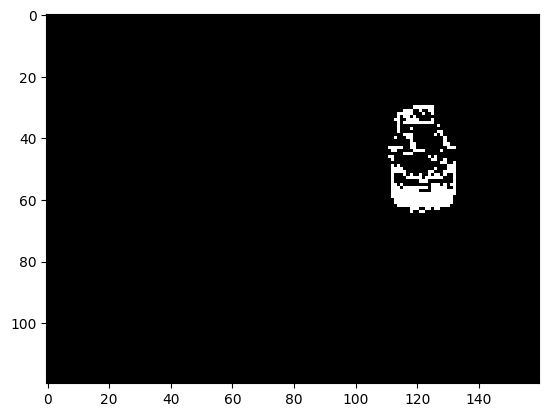

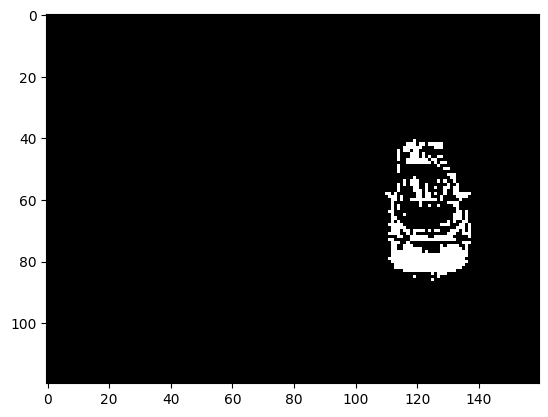

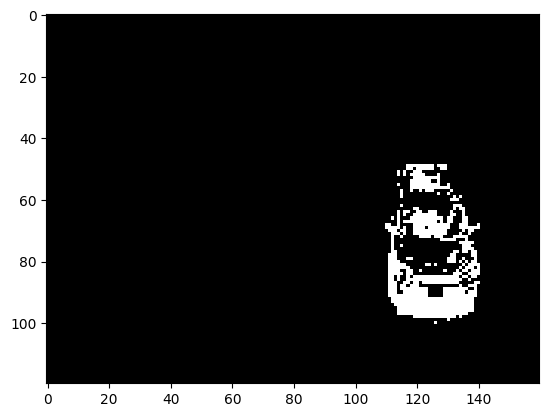

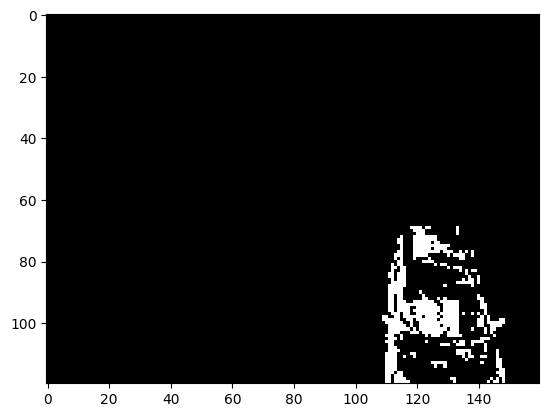

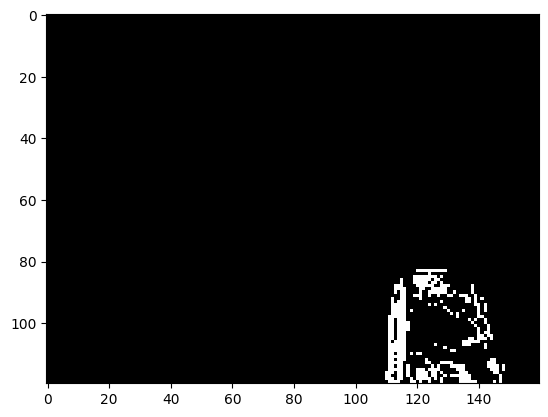

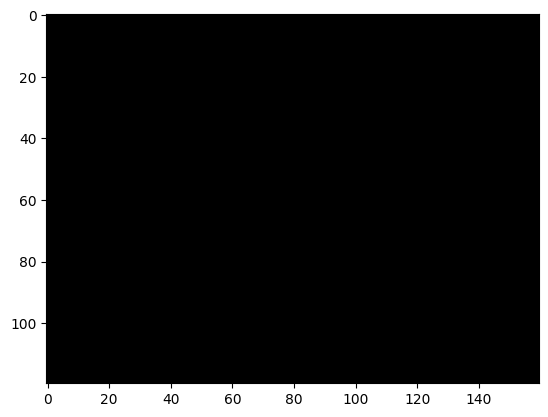

In [7]:
import imageio
frames = []
for i in range(test_frames.shape[0]):
    foregrounds = np.abs(test_frames[i]*255 - gmm_background*255)
    foregrounds = np.array(foregrounds,dtype='uint8')
    foregrounds = cv2.cvtColor(foregrounds, cv2.COLOR_BGR2GRAY)
    threshold = 50
    for i in range(foregrounds.shape[0]):
        for j in range(foregrounds.shape[1]):
            if foregrounds[i][j]<threshold:
                foregrounds[i][j]=0
            else:
                foregrounds[i][j]=255          
    #binary = np.where(foregrounds > threshold, 255, 0).astype(np.uint8)
    frames.append(foregrounds)
    plt.imshow(foregrounds,cmap='gray')
    plt.show()

In [ ]:
imageio.mimsave('foreground_animation.gif', frames, duration=0.1) #Please replace the local path by yours